In [1]:
class LudoEnv:
    def __init__(self):
        self.goal = 10
        self.num_players = 2
        self.pieces_per_player = 4
        self.state = [[0] * self.pieces_per_player for _ in range(self.num_players)] # 2D list representing player`s pieces positions
        self.current_player = 0  # The current player who is taking the turn (0 or 1)
        self.done = False  # Game over flag
        self.safe_spots = [5, 15, 25, 35, 45]  # List of safe spots where players can rest their pieces (not affected by other players)

    def reset(self):
        self.state = [[0] * self.pieces_per_player for _ in range(self.num_players)] # Reset the state for a new game, all pieces are at the starting position
        self.current_player = 0
        self.done = False
        return self.get_state()

    def get_state(self):
        # Return the current state of the game(including each player's pieces positions & current player)
        return tuple(tuple(player) for player in self.state), self.current_player

    def get_valid_actions(self):
                # ترجع القطع التي يمكن تحريكها (أي التي لم تصل للهدف بعد)
        return [i for i, pos in enumerate(self.state[self.current_player]) if pos < self.goal]

    def move_piece(self, player, piece_index, steps):
                # تحريك قطعة اللاعب بمقدار خطوات معينة
        piece_position = self.state[player][piece_index] #الموضع الحالي للقطعة
        new_position = piece_position + steps # الموضع الجديد بعد التحريك

        # تحقق من الأكل
        opponent = 1 if player == 0 else 0 # تحديد اللاعب المنافس
                # التحقق مما إذا تم ضرب قطعة للخصم في مكان غير آمن
        for i in range(self.pieces_per_player):
            if self.state[opponent][i] == new_position:
                self.state[opponent][i] = 0  # إرجاع قطعة الخصم للبداية
                return 20, -5  # زيادة المكافأة + عقوبة أقل للخصم

        # تحقق من الخانات الآمنة
        if new_position in self.safe_spots:
            return 5, 0  # مكافأة صغيرة للوصول إلى خانة آمنة

        if new_position == self.goal:  # إذا وصلت إلى الهدف
            return 20, 0  # زيادة المكافأة

        return 0, 0

    def step(self, action):
        dice_roll = random.randint(1, 6)
        reward = 0
        player_pieces = self.state[self.current_player]

        # تحريك القطعة
        if player_pieces[action] < self.goal:
                        # إذا كانت القطعة لم تصل للنهاية فقم بتحريكها
            reward, penalty = self.move_piece(self.current_player, action, dice_roll)
            player_pieces[action] = min(self.goal, player_pieces[action] + dice_roll)

        # إذا تم أكل قطعة، إضافة العقوبة
        reward -= penalty

        # إذا كانت جميع القطع وصلت
        if all(p == self.goal for p in player_pieces):#التحقق إذا فاز اللاعب
            reward += 50
            self.done = True

        # تغيير الدور
        self.current_player = 1 - self.current_player #تبديل الدور للاعب الآخر

        return self.get_state(), reward, self.done

In [2]:
class QLearningAgent:
    def __init__(self, actions, alpha=0.2, gamma=0.95, epsilon=0.1):

        #جدول Q لتخزين (state, action) -> Q-value
        self.q_table = {}
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        #(مثلاً: [0,1,2,3])
        self.actions = actions

    def get_q_value(self, state, action):
        return self.q_table.get((state, action), 0.0)

    def choose_action(self, state, valid_actions):
        if random.random() < self.epsilon:
            return random.choice(valid_actions)
        q_vals = [self.get_q_value(state, a) for a in valid_actions]
        max_q = max(q_vals)
        best_actions = [a for a, q in zip(valid_actions, q_vals) if q == max_q]
        return random.choice(best_actions)

    def learn(self, state, action, reward, next_state, next_valid_actions):
        current_q = self.get_q_value(state, action)
        max_next_q = max([self.get_q_value(next_state, a) for a in next_valid_actions], default=0)

         # نحسب القيمة الجديدة باستخدام معادلة Q-Learning
        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        # update q-table
        self.q_table[(state, action)] = new_q

In [3]:
#Function to gradually decrease epsilon with a minimum threshold of 0.01
def update_epsilon(epsilon, decay_rate=0.9999):
    return max(0.01, epsilon * decay_rate)


env = LudoEnv()
agent = QLearningAgent(actions=list(range(4))) # Initialize the Q-learning agent with 4 possible actions (representing the 4 pieces)


episodes = 10000
reward_per_episode = [] # List to store the total reward obtained in each episode

import random

for episode in range(episodes):
    state = env.reset()  # Reset the environment and get the initial state
    total_reward = 0 # Initialize the total reward for this episode
    while True:
        valid_actions = env.get_valid_actions() # Get the list of valid actions for the current state
        if not valid_actions:
            break
        action = agent.choose_action(state, valid_actions) # Let the agent choose an action (either explore or exploit)
        next_state, reward, done = env.step(action) # Perform the action and get the next state, reward, and done flag
        next_valid_actions = env.get_valid_actions() # Get the valid actions for the next state
        agent.learn(state, action, reward, next_state, next_valid_actions) # Update the Q-table using the learning algorithm
        state = next_state # Move to the next state
        total_reward += reward # Accumulate the total reward for this episode

        # If the game is finished ------> exit the loop
        if done:
            break
    reward_per_episode.append(total_reward) # Store the total reward for this episode

    # Gradually reduce the epsilon value to shift from exploration to exploitation
    agent.epsilon = update_epsilon(agent.epsilon)


print("Training done!")
print("Rewards per episode: ", reward_per_episode[:50])  # Display the total rewards for the first 50 episodes as a sample

Training done!
Rewards per episode:  [130, 195, 140, 250, 315, 255, 235, 260, 290, 185, 320, 175, 165, 180, 185, 285, 345, 280, 365, 155, 300, 160, 250, 245, 140, 220, 205, 395, 295, 325, 395, 285, 215, 290, 155, 315, 255, 285, 240, 210, 185, 315, 220, 320, 205, 265, 210, 180, 370, 160]


In [4]:
import numpy as np
def evaluate_agent(env, agent, episodes=100):
    total_rewards = []
    for _ in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            valid_actions = env.get_valid_actions()
            if not valid_actions:
                break

            action = agent.choose_action(state, valid_actions)

            next_state, reward, done = env.step(action)
            state = next_state
            total_reward += reward

        total_rewards.append(total_reward)

    avg_reward = np.mean(total_rewards)
    return avg_reward

Average Reward over 100 episodes: 260.65


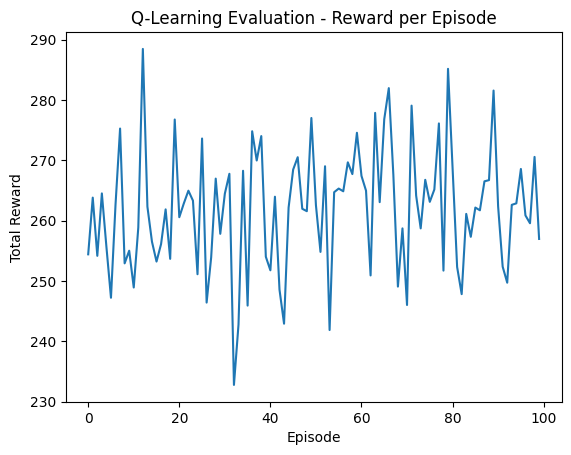

In [5]:
import matplotlib.pyplot as plt
env = LudoEnv()
agent = QLearningAgent(actions=list(range(4)))

avg_reward = evaluate_agent(env, agent, episodes=100)
print(f"Average Reward over 100 episodes: {avg_reward}")
total_rewards = [evaluate_agent(env, agent) for _ in range(100)]

plt.plot(total_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Q-Learning Evaluation - Reward per Episode")
plt.show()

In [6]:
# Sum all the rewards across the episodes
total_cumulative_reward = np.sum(reward_per_episode)  # Total rewards achieved across all episodes

# Define the window size for moving average calculation
window_size = 100  # The number of episodes (100) to consider for the moving average

# Calculate the moving average of rewards over 100 episodes
moving_avg_rewards = [
    np.mean(reward_per_episode[i:i+window_size])  # Calculate the average reward for each 100-episode window
    for i in range(len(reward_per_episode) - window_size)  # Loop through the episodes, creating 100-episode windows
]

# Determine the first time the rewards stabilize based on two conditions: standard deviation and average reward
convergence_time = next(
    (i for i in range(len(moving_avg_rewards))  # Loop through the moving averages
     if np.std(moving_avg_rewards[i:i+10]) < 1  # If the standard deviation of the rewards in the last 10 episodes is less than 1 (stabilization)
     and np.mean(moving_avg_rewards[i:i+10]) > 50),  # If the average reward in the last 10 episodes is greater than 50 (good performance)
    -1  # If no stabilization point is found, return -1
)

Cumulative Reward: 2624270
Convergence Time (Episode): 0
Robustness (Mean Reward over Variations): 263.5315, Standard Deviation: 1.613121198174515


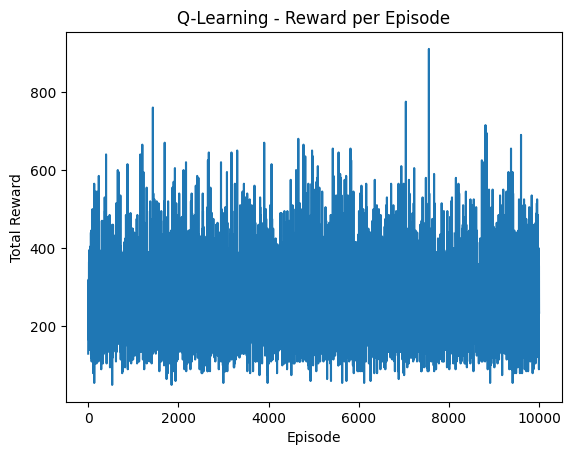

In [7]:
def test_robustness(variations=5):
    results = []
    for _ in range(variations):
        env = LudoEnv()
        agent = QLearningAgent(actions=list(range(4)))
        reward_per_episode_variation = []
        for episode in range(episodes):
            state = env.reset()
            total_reward = 0
            while True:
                valid_actions = env.get_valid_actions()
                if not valid_actions:
                    break
                action = agent.choose_action(state, valid_actions)
                next_state, reward, done = env.step(action)
                next_valid_actions = env.get_valid_actions()
                agent.learn(state, action, reward, next_state, next_valid_actions)
                state = next_state
                total_reward += reward
                if done:
                    break
            reward_per_episode_variation.append(total_reward)
        results.append(np.mean(reward_per_episode_variation))
    return np.mean(results), np.std(results)  # Return mean and standard deviation for robustness

robustness_mean, robustness_std = test_robustness()

# Display the evaluation metrics
print(f"Cumulative Reward: {total_cumulative_reward}")
print(f"Convergence Time (Episode): {convergence_time}")
print(f"Robustness (Mean Reward over Variations): {robustness_mean}, Standard Deviation: {robustness_std}")

# Plot results for visualization
plt.plot(reward_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Q-Learning - Reward per Episode")
plt.show()
